This notebook uses PySpark to analyse the Hackernews dataset obtained through BigQuery from the oldest date (2014-01-01 00:00:00 UTC) to 2024-01-01 23:59:59 UTC

The query used to retrieve data from BigQuery is as follows.<br/>
select * from bigquery-public-data.hacker_news.full
where title is not null and url is not null and text is not null and type = 'story' and timestamp >= '2014-01-01 00:00:00 UTC' and timestamp <= '2024-01-01 23:59:59 UTC' limit 100000;

In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=daccc865a5353d41cacfc42c16612896020629cb973a2d9381a8f0a562e4bf9f
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, FloatType, BooleanType, LongType, TimestampType
from pyspark.sql.functions import col, count, when, isnan, expr, year, asc

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hackernews/hackernews.csv


In [4]:
spark = SparkSession.builder.appName('Hackernews Analysis').getOrCreate()
print('Spark Version: {}'.format(spark.version))

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/11 11:31:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Version: 3.5.0


Loading Data with defined schema

In [5]:
schema = StructType([StructField('title', StringType(), nullable = True),
                     StructField('url', StringType(), nullable = True),
                     StructField('text', StringType(), nullable = True),
                     StructField('dead', BooleanType(), nullable = True),
                     StructField('by', StringType(), nullable = True),
                     StructField('score', IntegerType(), nullable = True),
                     StructField('time', LongType(), nullable = True),
                     StructField('timestamp', TimestampType(), nullable = True),
                     StructField('type', StringType(), nullable = True),
                     StructField('id', LongType(), nullable = True),
                     StructField('parent', LongType(), nullable = True),
                     StructField('descendants', LongType(), nullable = True),
                     StructField('ranking', LongType(), nullable = True),
                     StructField('deleted', BooleanType(), nullable = True)])

file_path = '/kaggle/input/hackernews/hackernews.csv'

df = spark.read.csv(file_path,
                    header = True,
                    inferSchema = True)

df.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+-----------+--------------------+------+--------+-------+-----------+----------+--------------------+
|               title|                 url|                text|                dead|                  by|        score|       time|           timestamp|  type|      id| parent|descendants|   ranking|             deleted|
+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+-----------+--------------------+------+--------+-------+-----------+----------+--------------------+
|Show HN: Automati...|https://use.trovi...|Stop wasting time...|                NULL|               ExxKA|            2| 1667214840|2022-10-31 11:14:...| story|33404245|   NULL|          4|      NULL|                NULL|
|Show HN: Destruct...|http://www.destru...|What is Destructi...|                NULL|           quematech|      

In [6]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----+---+----+-----+---+-----+----+---------+----+---+------+-----------+-------+-------+
|title|url|text| dead| by|score|time|timestamp|type| id|parent|descendants|ranking|deleted|
+-----+---+----+-----+---+-----+----+---------+----+---+------+-----------+-------+-------+
|    0|  0|   0|25673|508|  274| 182|      135|  89| 66| 97676|       4194|  98116|  98726|
+-----+---+----+-----+---+-----+----+---------+----+---+------+-----------+-------+-------+



In [10]:
df.createOrReplaceTempView("hackernews_data")

In [11]:
result = spark.sql("SELECT * FROM hackernews_data")
result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+----------+--------------------+
|               title|                 url|                text|                dead|                  by|               score|                time|           timestamp|                type|                  id|              parent|descendants|   ranking|             deleted|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+----------+--------------------+
|Show HN: Automati...|https://use.trovi...|Stop wasting time...|                NULL|               ExxKA|                   2|          1667214840|2022-10-31 11:14:...|

In [28]:
# Filter data for the year 2015 and where URL is not empty
filtered_data = df.filter(df["timestamp"].between("2015-01-01", "2015-12-31") & (df["url"] != ""))

# Extract top referenced sites using regular expression
top_sites_of_2015 = filtered_data.withColumn("top_sites_of_2015", expr("REGEXP_EXTRACT(url, '//([^/]*)/?')"))

# Group by top referenced sites and count the number of posts
count_by_site = top_sites_of_2015.groupBy("top_sites_of_2015").agg({"*": "count"}).withColumnRenamed("count(1)", "count_of_posts")

# Count the number of popular posts (score > 50) for each referenced site
count_of_popular_posts = top_sites_of_2015.filter("score > 50").groupBy("top_sites_of_2015").agg({"*": "count"}).withColumnRenamed("count(1)", "count_of_popular_posts")

# Join the two DataFrames on top referenced sites
result = count_by_site.join(count_of_popular_posts, "top_sites_of_2015", "left_outer").orderBy("count_of_popular_posts", ascending=False).limit(10)

# Show the result
result.show()

+--------------------+--------------+----------------------+
|   top_sites_of_2015|count_of_posts|count_of_popular_posts|
+--------------------+--------------+----------------------+
|        assembly.com|             2|                     2|
|       blogs.wsj.com|             1|                     1|
|google-latlong.bl...|             1|                     1|
|          medium.com|             3|                     1|
|    en.wikipedia.org|             3|                     1|
|         www.adp.com|             1|                     1|
| j00ru.vexillium.org|             1|                     1|
|chriskohlhepp.wor...|             1|                     1|
|    thehacktimes.com|             2|                     1|
|     paperwork.rocks|             1|                     1|
+--------------------+--------------+----------------------+



In [37]:
# Filter out null values in the timestamp column and ensure it's a valid date
df_filtered = df.filter(col("timestamp").isNotNull()) \
                .filter(col("timestamp").rlike("\\d{4}-\\d{2}-\\d{2} \\d{2}:\\d{2}:\\d{2}"))

# Extract the year from the timestamp column
df_with_year = df_filtered.withColumn("year", year("timestamp"))

# Group the stories by year and count the number of stories in each year
stories_by_year = df_with_year.groupBy("year").agg(count("*").alias("number_of_stories"))

# Order the result by year in ascending order
stories_by_year_ordered = stories_by_year.orderBy(asc("year"))

# Show the result
stories_by_year_ordered.show()

+----+-----------------+
|year|number_of_stories|
+----+-----------------+
|2007|             1168|
|2008|             5055|
|2009|             9905|
|2010|            12994|
|2011|            27852|
|2012|            24814|
|2013|             8843|
|2014|             4898|
|2015|              371|
|2016|                1|
|2017|                3|
|2018|               18|
|2019|                9|
|2020|               13|
|2021|                9|
|2022|             1670|
+----+-----------------+



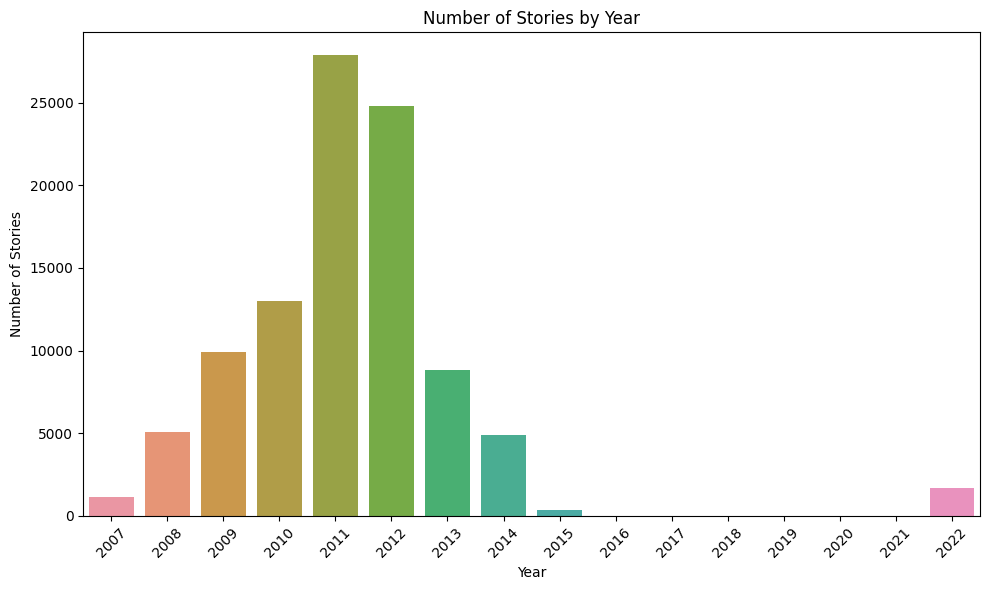

In [44]:
# Extracting year and number_of_stories values from the DataFrame
years = stories_by_year.select("year").rdd.flatMap(lambda x: x).collect()
story_counts = stories_by_year.select("number_of_stories").rdd.flatMap(lambda x: x).collect()

# Creating a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='number_of_stories', data=stories_by_year.toPandas())
plt.title('Number of Stories by Year')
plt.xlabel('Year')
plt.ylabel('Number of Stories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()